# Component Detection Model Lifecycle

![AI Lifecycle](./assets/lifecycle.png)


## Step 3: Data Exploration

In [1]:
import numpy as np
import pandas as pd
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

from pathlib import Path
import xml.etree.ElementTree as ET
from shutil import copyfile
import os
import os.path as path
import shutil
import pathlib
from pathlib import Path
from tqdm.std import tqdm
import random
import glob
import cv2
import regex as re
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from ultralytics import YOLO
from ultralytics.utils.metrics import DetMetrics
import enum
from enum import Enum, auto

import sys

sys.path.insert(0, "..")
from yolo_visualize import sample_yolo_dataset

In [2]:
%matplotlib inline

In [3]:
FINAL_DATA_DIR = Path("./components_data")

In [4]:
@enum.verify(enum.UNIQUE, enum.CONTINUOUS)
class Component(enum.IntEnum):
    battery = 0
    button = 1
    buzzer = 2
    capacitor = 3
    clock = 4
    connector = 5
    diode = 6
    display = 7
    fuse = 8
    heatsink = 9
    ic = 10
    inductor = 11
    led = 12
    pads = 13
    pins = 14
    potentiometer = 15
    relay = 16
    resistor = 17
    switch = 18
    transducer = 19
    transformer = 20
    transistor = 21


Component.aliases = {
    # Plurals
    "diodes": Component.diode,
    "resistors": Component.resistor,
    "transistors": Component.transistor,
    "capacitors": Component.capacitor,
    "inductors": Component.inductor,
    "fuses": Component.fuse,
    "ics": Component.ic,
    "transducers": Component.transducer,
    "transformers": Component.transformer,
    #
    # Subsets
    "electrolytic_capacitor": Component.capacitor,
    "capacitor_jumper": Component.capacitor,
    "resistor_jumper": Component.resistor,
    "jumper": Component.connector,
    "zener_diode": Component.diode,
    #
    # Look like ICs
    "diode_zener_array": Component.ic,
    "resistor_network": Component.ic,
    #
    # Look like SMD capacitors, and are very hard to tell apart
    "ferrite_bead": Component.capacitor,
    "emi_filter": Component.capacitor,
}

CLASSES = list(Component._member_names_)
CLASSES

['battery',
 'button',
 'buzzer',
 'capacitor',
 'clock',
 'connector',
 'diode',
 'display',
 'fuse',
 'heatsink',
 'ic',
 'inductor',
 'led',
 'pads',
 'pins',
 'potentiometer',
 'relay',
 'resistor',
 'switch',
 'transducer',
 'transformer',
 'transistor']

100%|██████████| 18/18 [00:01<00:00, 16.36it/s]


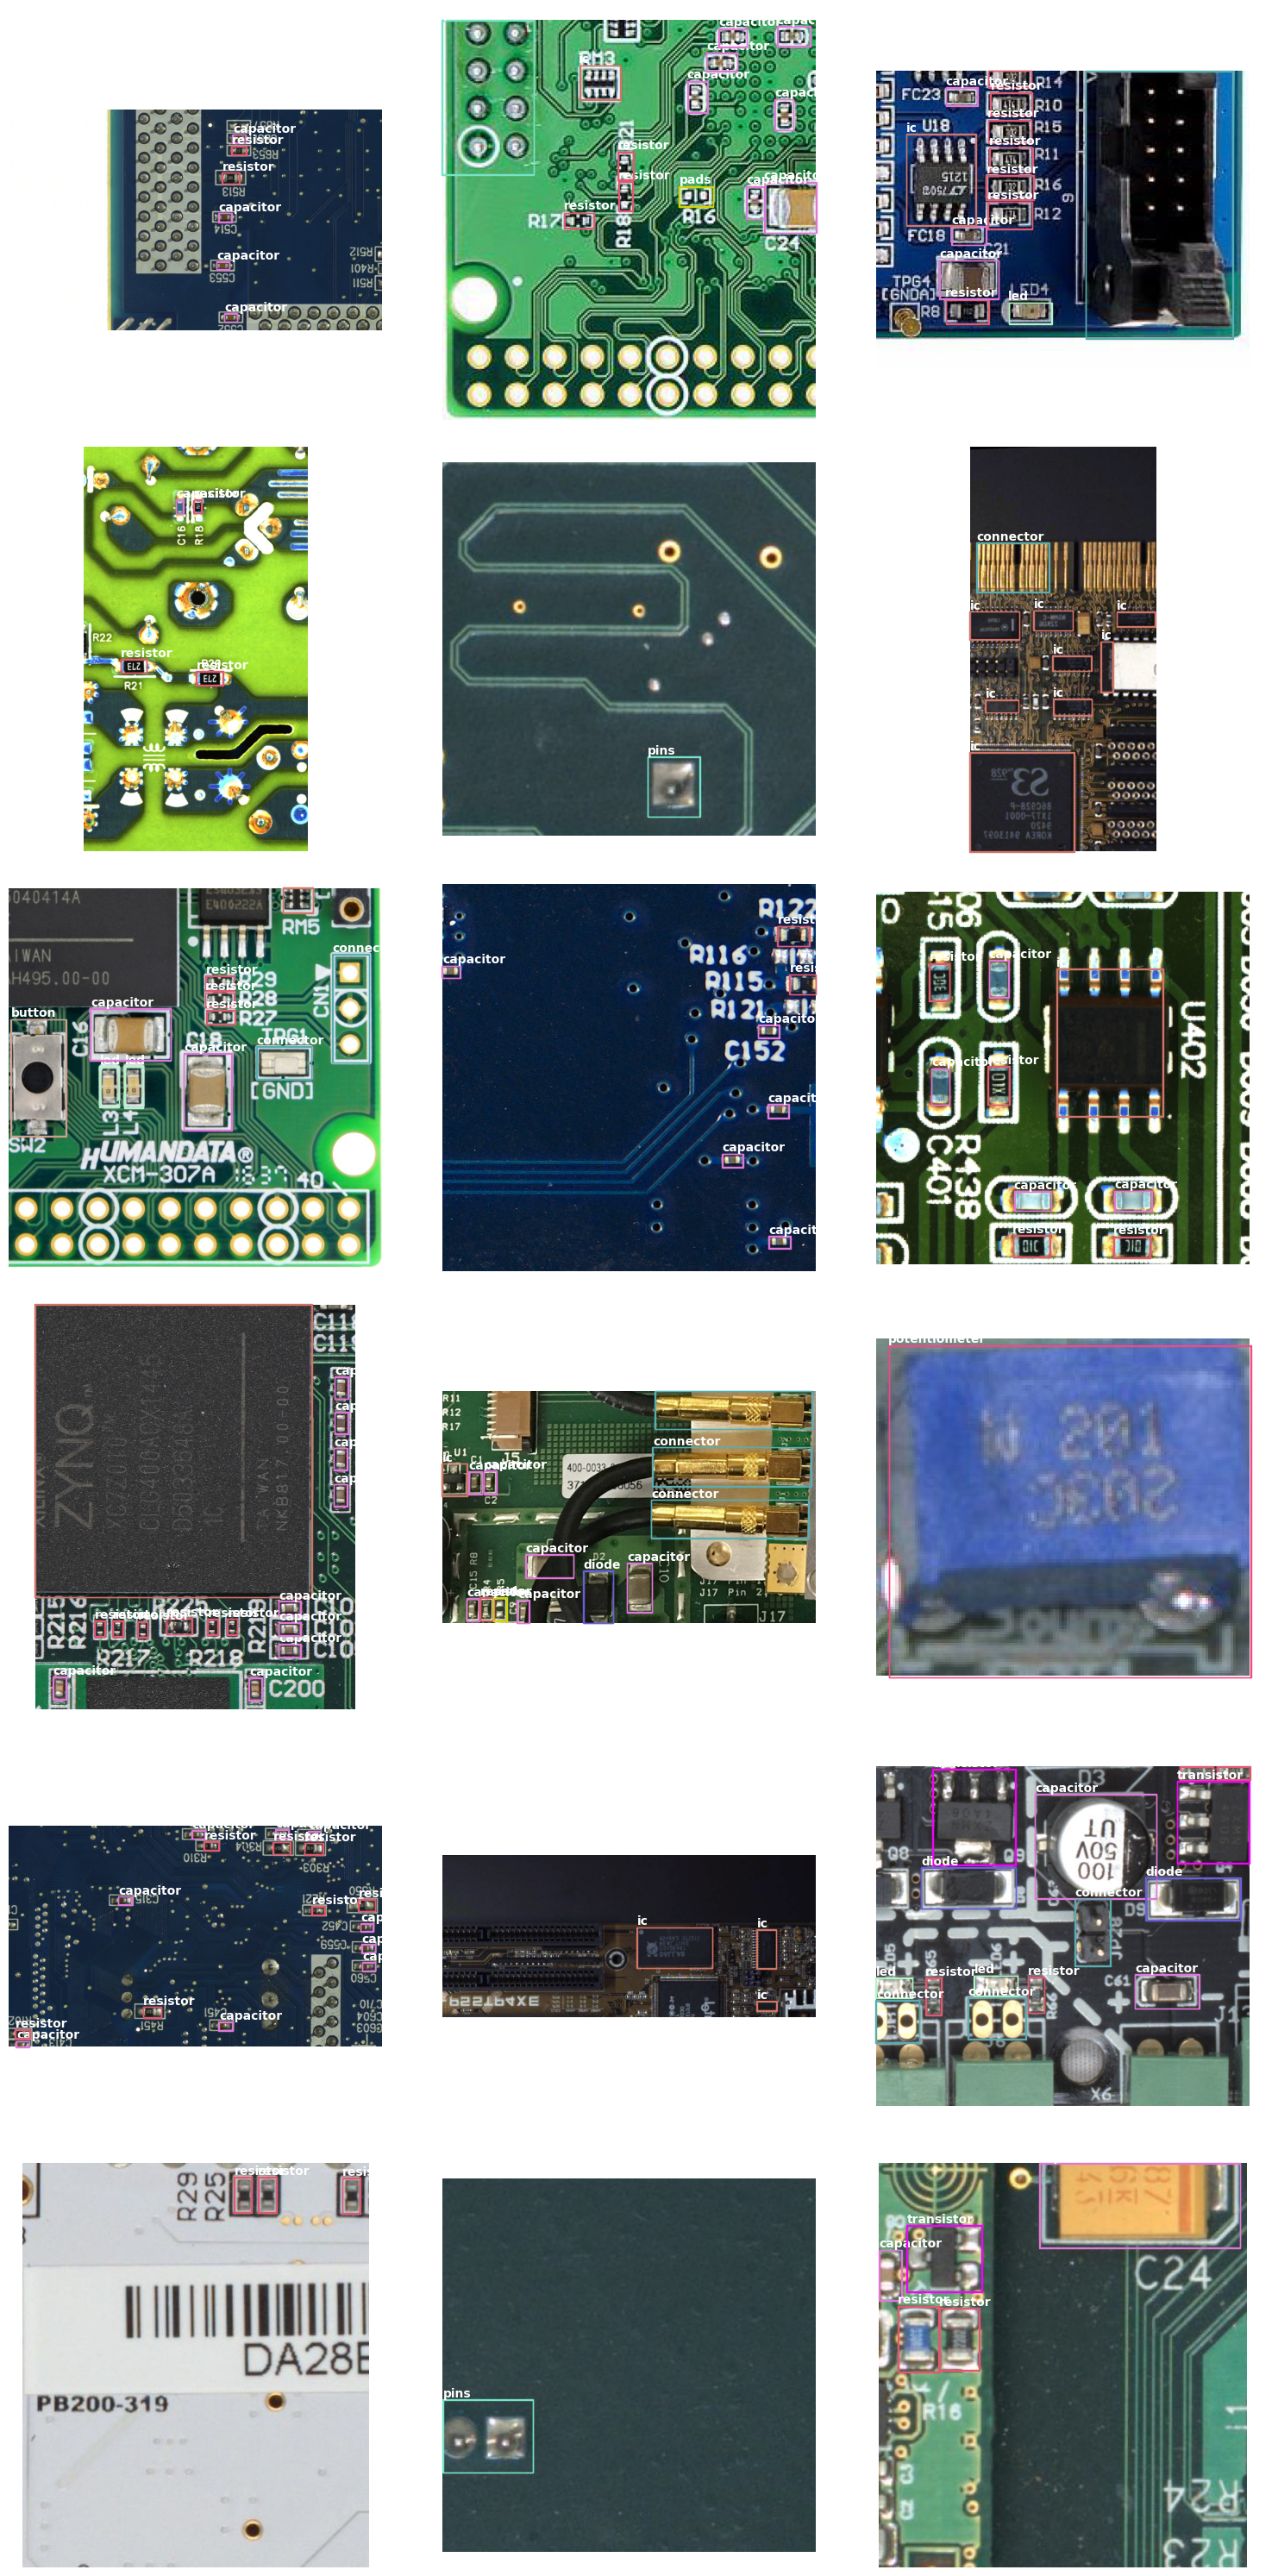

In [5]:
sample_yolo_dataset(FINAL_DATA_DIR / "train", CLASSES)

### Step 4: Modelling: Train a YOLOv11 Model

See ./modelling_components.py

### Step 5: Evaluation:

Define an evalutation function that evaluates a model in 4 ways:
 - on the entire dataset
 - on the entire dataset, with single class (by combining all classes into i.e. consider all component types as the same)

In [6]:
def eval_model(model: YOLO, model_name: str):
    results1: DetMetrics = model.val(
        data=FINAL_DATA_DIR / "data.yaml",
        device=0,
        batch=16,
        cache="disk",
        save_json=True,
        iou=0.7,
        plots=True,
        split="val",
        verbose=True,
        project=model_name,
        name="val_full_dataset",
    )
    results2 = model.val(
        data=FINAL_DATA_DIR / "data.yaml",
        device=0,
        batch=16,
        cache="disk",
        save_json=True,
        iou=0.7,
        plots=True,
        split="val",
        verbose=True,
        single_cls=True,
        project=model_name,
        name="val_full_dataset_single_cls",
    )
    r2 = results2.summary()
    r2[0]["class_name"] = "Combined"
    return pd.concat(
        [
            pd.DataFrame(results1.summary()).set_index("class_name"),
            pd.DataFrame(r2).set_index("class_name"),
        ],
        axis=0,
        keys=["Full", "Full (Single Class)"],
    )

#### Evaluate the best model trained on uncropped images

In [7]:
model_best_small = YOLO("yolo11n_best_small_component.pt")

In [8]:
model_best_small_res = eval_model(model_best_small, "yolo11n_small_components")
model_best_small_res

Ultralytics 8.3.154  Python-3.12.4 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
YOLO11n summary (fused): 100 layers, 2,586,442 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 5.97.2 MB/s, size: 181.4 KB)


val: Scanning E:\PythonProjects\pcb\pcb-components-detection\components_data\valid\labels.cache... 834 images, 3 backgrounds, 0 corrupt: 100%|██████████| 834/834 [00:00<?, ?it/s]
val: Caching images (2.2GB Disk): 100%|██████████| 834/834 [00:00<00:00, 12200.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:20<00:00,  2.63it/s]


                   all        834      10862      0.688       0.36      0.398      0.237
               battery          7          7      0.722      0.857      0.865      0.576
                button         14         22          1          0     0.0477     0.0106
                buzzer         13         13      0.724      0.692      0.708       0.44
             capacitor        580       3713      0.708      0.371      0.454      0.195
                 clock         31         36          1     0.0829      0.233      0.136
             connector        185        414      0.508      0.174      0.213      0.123
                 diode        126        235      0.442     0.0894      0.213      0.099
               display          9         10      0.303        0.6      0.329      0.254
                  fuse          4         45      0.605        0.4      0.457      0.201
                    ic        357       1350      0.639      0.694      0.675      0.384
              inducto

val: Scanning E:\PythonProjects\pcb\pcb-components-detection\components_data\valid\labels.cache... 834 images, 3 backgrounds, 0 corrupt: 100%|██████████| 834/834 [00:00<?, ?it/s]
val: Caching images (2.2GB Disk): 100%|██████████| 834/834 [00:00<00:00, 8376.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.39it/s]


                   all        834      10862      0.643      0.517      0.528      0.252
               battery        831      10862      0.643      0.517      0.528      0.252
Speed: 0.5ms preprocess, 9.1ms inference, 0.0ms loss, 4.4ms postprocess per image
Saving yolo11n_small_components\val_full_dataset_single_cls\predictions.json...
Results saved to yolo11n_small_components\val_full_dataset_single_cls


box-p    box-r   box-f1  box-map  \
                    class_name                                          
Full                battery        0.72238  0.85714  0.78401  0.23668   
                    button         1.00000  0.00000  0.00000  0.23668   
                    buzzer         0.72439  0.69231  0.70798  0.23668   
                    capacitor      0.70754  0.37140  0.48711  0.23668   
                    clock          1.00000  0.08291  0.15312  0.23668   
                    connector      0.50793  0.17391  0.25911  0.23668   
                    diode          0.44219  0.08936  0.14868  0.23668   
                    display        0.30268  0.60000  0.40238  0.23668   
                    fuse           0.60530  0.40000  0.48169  0.23668   
                    ic             0.63890  0.69407  0.66535  0.23668   
                    inductor       0.53344  0.16667  0.25398  0.23668   
                    led            0.68426  0.24381  0.35952  0.23668   
                    pads           1.00000  0.00000  0.00000  0.23668   
                    pins           1.00000  0.00000  0.00000  0.23668   
                    potentiometer  0.32502  0.11111  0.16561  0.23668   
                    relay          0.72360  1.00000  0.83964  0.23668   
                    resistor       0.83497  0.33821  0.48142  0.23668   
                    switch         0.64591  0.66102  0.65338  0.23668   
                    transistor     0.67335  0.35108  0.46152  0.23668   
Full (Single Class) Combined       0.64317  0.51657  0.57296  0.25156   

                                   box-map50  box-map75  
                    class_name                           
Full                battery          0.39795    0.23741  
                    button           0.39795    0.23741  
                    buzzer           0.39795    0.23741  
                    capacitor        0.39795    0.23741  
                    clock            0.39795    0.23741  
                    connector        0.39795    0.23741  
                    diode            0.39795    0.23741  
                    display          0.39795    0.23741  
                    fuse             0.39795    0.23741  
                    ic               0.39795    0.23741  
                    inductor         0.39795    0.23741  
                    led              0.39795    0.23741  
                    pads             0.39795    0.23741  
                    pins             0.39795    0.23741  
                    potentiometer    0.39795    0.23741  
                    relay            0.39795    0.23741  
                    resistor         0.39795    0.23741  
                    switch           0.39795    0.23741  
                    transistor       0.39795    0.23741  
Full (Single Class) Combined         0.52821    0.21353

#### Evaluate the best model trained on tiled (zoomed & cropped) images

In [9]:
model_best_zoom = YOLO("yolo11n_best_zoomed.pt")

In [10]:
model_best_zoom_res = eval_model(model_best_zoom, "yolo11n_zoomed")
model_best_zoom_res

Ultralytics 8.3.154  Python-3.12.4 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
YOLO11n summary (fused): 100 layers, 2,586,442 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.20.1 ms, read: 3.23.4 MB/s, size: 107.3 KB)


val: Scanning E:\PythonProjects\pcb\pcb-components-detection\components_data\valid\labels.cache... 834 images, 3 backgrounds, 0 corrupt: 100%|██████████| 834/834 [00:00<?, ?it/s]
val: Caching images (2.2GB Disk): 100%|██████████| 834/834 [00:00<00:00, 8919.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:23<00:00,  2.29it/s]


                   all        834      10862       0.64      0.547      0.582      0.363
               battery          7          7      0.524      0.714      0.829      0.674
                button         14         22      0.887      0.364      0.423      0.288
                buzzer         13         13          1      0.727      0.846      0.596
             capacitor        580       3713      0.827      0.631      0.688      0.419
                 clock         31         36      0.498      0.333      0.413      0.232
             connector        185        414      0.586      0.444      0.443      0.273
                 diode        126        235      0.639      0.485      0.506      0.279
               display          9         10      0.295        0.8      0.693      0.516
                  fuse          4         45      0.641      0.711      0.775      0.315
                    ic        357       1350      0.653      0.832       0.79       0.45
              inducto

val: Scanning E:\PythonProjects\pcb\pcb-components-detection\components_data\valid\labels.cache... 834 images, 3 backgrounds, 0 corrupt: 100%|██████████| 834/834 [00:00<?, ?it/s]
val: Caching images (2.2GB Disk): 100%|██████████| 834/834 [00:00<00:00, 4447.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:18<00:00,  2.79it/s]


                   all        834      10862      0.823      0.664      0.721      0.415
               battery        831      10862      0.823      0.664      0.721      0.415
Speed: 0.6ms preprocess, 8.8ms inference, 0.0ms loss, 3.9ms postprocess per image
Saving yolo11n_zoomed\val_full_dataset_single_cls\predictions.json...
Results saved to yolo11n_zoomed\val_full_dataset_single_cls


box-p    box-r   box-f1  box-map  \
                    class_name                                          
Full                battery        0.52390  0.71429  0.60445  0.36264   
                    button         0.88723  0.36364  0.51585  0.36264   
                    buzzer         1.00000  0.72720  0.84206  0.36264   
                    capacitor      0.82743  0.63147  0.71629  0.36264   
                    clock          0.49806  0.33333  0.39938  0.36264   
                    connector      0.58613  0.44444  0.50555  0.36264   
                    diode          0.63938  0.48511  0.55166  0.36264   
                    display        0.29489  0.80000  0.43093  0.36264   
                    fuse           0.64141  0.71111  0.67446  0.36264   
                    ic             0.65347  0.83185  0.73195  0.36264   
                    inductor       0.53271  0.35088  0.42308  0.36264   
                    led            0.75293  0.45417  0.56657  0.36264   
                    pads           0.59105  0.05022  0.09258  0.36264   
                    pins           0.13562  0.25773  0.17773  0.36264   
                    potentiometer  0.71080  0.20545  0.31876  0.36264   
                    relay          0.63011  1.00000  0.77309  0.36264   
                    resistor       0.81739  0.67037  0.73662  0.36264   
                    switch         0.69472  0.69427  0.69449  0.36264   
                    transistor     0.74744  0.65911  0.70050  0.36264   
Full (Single Class) Combined       0.82266  0.66433  0.73507  0.41458   

                                   box-map50  box-map75  
                    class_name                           
Full                battery          0.58212    0.38966  
                    button           0.58212    0.38966  
                    buzzer           0.58212    0.38966  
                    capacitor        0.58212    0.38966  
                    clock            0.58212    0.38966  
                    connector        0.58212    0.38966  
                    diode            0.58212    0.38966  
                    display          0.58212    0.38966  
                    fuse             0.58212    0.38966  
                    ic               0.58212    0.38966  
                    inductor         0.58212    0.38966  
                    led              0.58212    0.38966  
                    pads             0.58212    0.38966  
                    pins             0.58212    0.38966  
                    potentiometer    0.58212    0.38966  
                    relay            0.58212    0.38966  
                    resistor         0.58212    0.38966  
                    switch           0.58212    0.38966  
                    transistor       0.58212    0.38966  
Full (Single Class) Combined         0.72145    0.43231

#### Evaluate the best model trained on tiled (zoomed & cropped) images, with only 7 frozen layers

In [11]:
model_best_thawed = YOLO("yolo11n_best_thawed.pt")

In [ ]:
model_best_thawed_res = eval_model(model_best_thawed, "yolo11n_thawed")
model_best_thawed_res

Ultralytics 8.3.154  Python-3.12.4 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)


YOLO11n summary (fused): 100 layers, 2,586,442 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 284.3568.4 MB/s, size: 2109.5 KB)


val: Scanning E:\PythonProjects\pcb\pcb-components-detection\components_data\valid\labels.cache... 834 images, 3 backgrounds, 0 corrupt: 100%|██████████| 834/834 [00:00<?, ?it/s]
val: Caching images (2.2GB Disk): 100%|██████████| 834/834 [00:00<00:00, 9988.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:20<00:00,  2.63it/s]


                   all        834      10862      0.657      0.579      0.616      0.385
               battery          7          7      0.481      0.714      0.698      0.462
                button         14         22      0.889      0.363      0.509      0.364
                buzzer         13         13      0.918      0.846      0.851      0.598
             capacitor        580       3713      0.853      0.626      0.701      0.423
                 clock         31         36      0.609      0.417      0.477      0.288
             connector        185        414      0.609      0.483      0.489      0.304
                 diode        126        235      0.684      0.552      0.606      0.341
               display          9         10      0.449        0.7      0.753      0.565
                  fuse          4         45      0.593        0.8      0.813      0.341
                    ic        357       1350      0.716       0.83      0.808      0.493
              inducto

val: Scanning E:\PythonProjects\pcb\pcb-components-detection\components_data\valid\labels.cache... 834 images, 3 backgrounds, 0 corrupt: 100%|██████████| 834/834 [00:00<?, ?it/s]
val: Caching images (2.2GB Disk): 100%|██████████| 834/834 [00:00<00:00, 13005.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:18<00:00,  2.83it/s]


                   all        834      10862      0.845      0.663      0.732      0.427
               battery        831      10862      0.845      0.663      0.732      0.427
Speed: 0.7ms preprocess, 9.4ms inference, 0.0ms loss, 2.6ms postprocess per image
Saving yolo11n_thawed\val_full_dataset_single_cls\predictions.json...
Results saved to yolo11n_thawed\val_full_dataset_single_cls


box-p    box-r   box-f1  box-map  \
                    class_name                                          
Full                battery        0.48056  0.71429  0.57457  0.38478   
                    button         0.88862  0.36275  0.51519  0.38478   
                    buzzer         0.91834  0.84615  0.88077  0.38478   
                    capacitor      0.85284  0.62589  0.72195  0.38478   
                    clock          0.60928  0.41667  0.49489  0.38478   
                    connector      0.60877  0.48309  0.53870  0.38478   
                    diode          0.68364  0.55175  0.61066  0.38478   
                    display        0.44909  0.70000  0.54715  0.38478   
                    fuse           0.59291  0.80000  0.68106  0.38478   
                    ic             0.71568  0.83037  0.76877  0.38478   
                    inductor       0.47205  0.39218  0.42842  0.38478   
                    led            0.68681  0.49583  0.57590  0.38478   
                    pads           0.31419  0.05019  0.08656  0.38478   
                    pins           0.21008  0.31959  0.25352  0.38478   
                    potentiometer  0.71059  0.40948  0.51956  0.38478   
                    relay          0.79690  1.00000  0.88697  0.38478   
                    resistor       0.86273  0.65675  0.74578  0.38478   
                    switch         0.87072  0.68504  0.76680  0.38478   
                    transistor     0.75751  0.66376  0.70754  0.38478   
Full (Single Class) Combined       0.84495  0.66326  0.74316  0.42653   

                                   box-map50  box-map75  
                    class_name                           
Full                battery          0.61576    0.41728  
                    button           0.61576    0.41728  
                    buzzer           0.61576    0.41728  
                    capacitor        0.61576    0.41728  
                    clock            0.61576    0.41728  
                    connector        0.61576    0.41728  
                    diode            0.61576    0.41728  
                    display          0.61576    0.41728  
                    fuse             0.61576    0.41728  
                    ic               0.61576    0.41728  
                    inductor         0.61576    0.41728  
                    led              0.61576    0.41728  
                    pads             0.61576    0.41728  
                    pins             0.61576    0.41728  
                    potentiometer    0.61576    0.41728  
                    relay            0.61576    0.41728  
                    resistor         0.61576    0.41728  
                    switch           0.61576    0.41728  
                    transistor       0.61576    0.41728  
Full (Single Class) Combined         0.73219    0.44990

### Step 6: Model Deployment

Take the model yolo11n_best_thawed.pt, as it does the best, and export it to ONNX, for deployment

In [2]:
final_model = YOLO("./yolo11n_best_thawed.pt")

In [3]:
final_model.export(format="onnx")

Ultralytics 8.3.160  Python-3.11.7 torch-2.7.0+cpu CPU (Intel Core(TM) i9-10900K 3.70GHz)
YOLO11n summary (fused): 100 layers, 2,586,442 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from 'yolo11n_best_thawed.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 26, 8400) (5.2 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.58...
ONNX: export success  3.4s, saved as 'yolo11n_best_thawed.onnx' (10.1 MB)

Export complete (3.6s)
Results saved to E:\PythonProjects\pcb\pcb-components-detection
Predict:         yolo predict task=detect model=yolo11n_best_thawed.onnx imgsz=640  
Validate:        yolo val task=detect model=yolo11n_best_thawed.onnx imgsz=640 data=components_data\data.yaml  
Visualize:       https://netron.app


'yolo11n_best_thawed.onnx'